In [1]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from numpy.linalg import norm

In [2]:
import sys
sys.path.append("./Libs")
from FcMole import FcM
from FDcoeffs import get_coeffs

In [4]:
n_321g=gto.basis.load(bse.get_basis("cc-pvtz",fmt="nwchem",elements=["N"]),"N")
c_321g=gto.basis.load(bse.get_basis("cc-pvtz",fmt="nwchem",elements=["C"]),"C")
n_321g,"*******************",c_321g

([[0,
   [11420.0, 0.000523, -0.000115, 0.0, 0.0],
   [1712.0, 0.004045, -0.000895, 0.0, 0.0],
   [389.3, 0.020775, -0.004624, 0.0, 0.0],
   [110.0, 0.080727, -0.018528, 0.0, 0.0],
   [35.57, 0.233074, -0.057339, 0.0, 0.0],
   [12.54, 0.433501, -0.132076, 0.0, 0.0],
   [4.644, 0.347472, -0.17251, 0.0, 0.0],
   [1.293, 0.041262, 0.151814, 1.0, 0.0],
   [0.5118, -0.008508, 0.599944, 0.0, 0.0],
   [0.1787, 0.002384, 0.387462, 0.0, 1.0]],
  [1,
   [26.63, 0.01467, 0.0, 0.0],
   [5.948, 0.091764, 0.0, 0.0],
   [1.742, 0.298683, 0.0, 0.0],
   [0.555, 0.498487, 1.0, 0.0],
   [0.1725, 0.337023, 0.0, 1.0]],
  [2, [1.654, 1.0, 0.0], [0.469, 0.0, 1.0]],
  [3, [1.093, 1.0]]],
 '*******************',
 [[0,
   [8236.0, 0.000531, -0.000113, 0.0, 0.0],
   [1235.0, 0.004108, -0.000878, 0.0, 0.0],
   [280.8, 0.021087, -0.00454, 0.0, 0.0],
   [79.27, 0.081853, -0.018133, 0.0, 0.0],
   [25.59, 0.234817, -0.05576, 0.0, 0.0],
   [8.997, 0.434401, -0.126895, 0.0, 0.0],
   [3.319, 0.346129, -0.170352, 0.0, 0.

In [5]:
def g321(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("cc-pvtz",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=g321(ref)
        rbm=g321(ref-1)
        rbp=g321(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):  
            for j in range(1,len(fb[i])):
                for k in range(len(fb[i][j])):
                    a=(rbp[i][j][k]-rbm[i][j][k])/2
                    b=(rbp[i][j][k]+rbm[i][j][k]-2*rb[i][j][k])
                    fb[i][j][k]+=a*(z-ref)+b*(z-ref)**2
        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

In [6]:
g321(6,ref=6),"**********",g321(6.5,ref=6),"**********",g321(7,ref=6)

([[0,
   [8236.0, 0.000531, -0.000113, 0.0, 0.0],
   [1235.0, 0.004108, -0.000878, 0.0, 0.0],
   [280.8, 0.021087, -0.00454, 0.0, 0.0],
   [79.27, 0.081853, -0.018133, 0.0, 0.0],
   [25.59, 0.234817, -0.05576, 0.0, 0.0],
   [8.997, 0.434401, -0.126895, 0.0, 0.0],
   [3.319, 0.346129, -0.170352, 0.0, 0.0],
   [0.9059, 0.039378, 0.140382, 1.0, 0.0],
   [0.3643, -0.008983, 0.598684, 0.0, 0.0],
   [0.1285, 0.002385, 0.395389, 0.0, 1.0]],
  [1,
   [18.71, 0.014031, 0.0, 0.0],
   [4.133, 0.086866, 0.0, 0.0],
   [1.2, 0.290216, 0.0, 0.0],
   [0.3827, 0.501008, 1.0, 0.0],
   [0.1209, 0.343406, 0.0, 1.0]],
  [2, [1.097, 1.0, 0.0], [0.318, 0.0, 1.0]],
  [3, [0.761, 1.0]]],
 '**********',
 [[0,
   [9828.0, 0.000527, -0.00011399999999999999, 0.0, 0.0],
   [1473.5, 0.0040765, -0.0008864999999999999, 0.0, 0.0],
   [335.05, 0.020930999999999998, -0.004581999999999999, 0.0, 0.0],
   [94.63499999999999, 0.08128999999999999, -0.0183305, 0.0, 0.0],
   [30.58, 0.2339455, -0.056549499999999996, 0.0, 0.0],


In [7]:
def E(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7,ref=7),"N2":g321(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

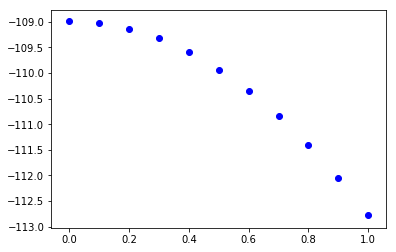

In [8]:
for i in np.linspace(0,1,11):
    plt.scatter(i,E(i),color="blue")

In [14]:
eT_R=E(-1,zbs=False)

In [9]:
e_co=scf.RHF(gto.M(atom="C 0 0 0; O 0 0 2.05",unit="Bohrs",basis=bse.get_basis("cc-pvtz"\
                                                       ,fmt="nwchem",elements=["C","N","O"]))).scf()
e_nn=scf.RHF(gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("cc-pvtz"\
                                                       ,fmt="nwchem",elements=["C","N","O"]))).scf()

converged SCF energy = -112.780713469478
converged SCF energy = -108.985493724474


In [10]:
#5pts finite difference coefficients
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

In [11]:
dl=.1
Es=np.asarray([E(-3*dl),E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl),E(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft,e_co,inc

([-108.9854937244738,
  -108.98549372447441,
  -112.78766495130144,
  -112.7876649512893,
  -112.76364336604243,
  -112.76364336609572,
  -112.81834762485809],
 -112.7807134694777,
 [-6.150635556423367e-13,
  -3.8021712268270216,
  1.2138438402568376e-11,
  0.024021585246873176,
  -5.32907051820075e-11,
  -0.05470425876236755])

In [12]:
dl=.1
Es=np.asarray([E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl)])
apdft=[e_nn]
inc=[]
for i in range(4):
    inc.append(fds5[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds5[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,e_co,inc

([-108.9854937244738,
  -108.98549372447252,
  -112.78764306956272,
  -112.78764306960535,
  -112.76635669813099],
 -112.7807134694777,
 [1.2789769243681803e-12,
  -3.802149345090199,
  -4.2632564145606005e-11,
  0.021286371474360518])

In [15]:
dl=.05
Es=np.asarray([E(-3*dl,zbs=False),E(-2*dl,zbs=False),E(-dl,zbs=False),e_nn,E(dl,zbs=False),E(2*dl,zbs=False),E(3*dl,zbs=False)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,eT_R,e_co,inc

([-108.9854937244738,
  -108.9854937244772,
  -112.31293739539062,
  -112.31293739497613,
  -112.30383088046477,
  -112.30383089391772,
  -112.30318180649687],
 -112.30323169606025,
 -112.7807134694777,
 [-3.397282455352979e-12,
  -3.327443670913421,
  4.14483262526725e-10,
  0.009106514511358908,
  -1.345294246372456e-08,
  0.0006490874208490517])

In [25]:
def E_cn(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7)},verbose=1)
    elif not zbs:
        mol_l=FcM(fcs=[-l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7,ref=7),"N2":g321(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

In [26]:
mf_cn=scf.RHF(gto.M(atom="C 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("cc-pvtz"\
                                                       ,fmt="nwchem",elements=["C","N","O"]),charge=-1))
e_cn=mf_cn.scf()

converged SCF energy = -92.3220582208861


In [32]:
dl=.1
Es=np.asarray([E_cn(-3*dl),E_cn(-2*dl),E_cn(-dl),e_nn,E_cn(dl),E_cn(2*dl),E_cn(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
apdft,e_cn,apdft-e_cn,inc

(array([-108.98549372,  -90.70791575,  -92.35983148,  -92.31978224,
         -92.32078066,  -92.3184192 ,  -92.3174632 ]),
 -92.32205822088608,
 array([-1.66634355e+01,  1.61414247e+00, -3.77732604e-02,  2.27598547e-03,
         1.27756490e-03,  3.63902503e-03,  4.59501985e-03]),
 [18.277577970673757,
  -1.651915727449049,
  0.04004924583493144,
  -0.000998420569923534,
  0.0023614601237416837,
  0.000955994828978469])

In [31]:
dl=.1
Es=np.asarray([E_cn(-3*dl,zbs=False),E_cn(-2*dl,zbs=False),E_cn(-dl,zbs=False),e_nn,E_cn(dl,zbs=False),E_cn(2*dl,zbs=False),E_cn(3*dl,zbs=False)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
apdft,E_cn(1,zbs=False),e_cn,apdft-E_cn(1,zbs=False),apdft-e_cn,inc

(array([-108.98549372,  -90.70787059,  -92.11865025,  -92.16250308,
         -92.16130771,  -92.15958433,  -92.15917483]),
 -92.15921844912398,
 -92.32205822088608,
 array([-1.68262753e+01,  1.45134786e+00,  4.05681949e-02, -3.28462702e-03,
        -2.08926441e-03, -3.65879314e-04,  4.36170440e-05]),
 array([-16.6634355 ,   1.61418763,   0.20340797,   0.15955514,
          0.16075051,   0.16247389,   0.16288339]),
 [18.27762313181324,
  -1.4107796615851596,
  -0.04385282189645067,
  0.0011953626074164463,
  0.0017233850968523252,
  0.00040949635781038914])

In [26]:
#check if basis are orthonormal

In [19]:
def S(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7,ref=7),"N2":g321(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    #e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return mf_l.get_ovlp()

In [20]:
for i in np.linspace(0,1,7):
    print(S(i).diagonal())  #automatic normalization

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

(<matplotlib.image.AxesImage at 0x7f891e47a2b0>,
 <matplotlib.image.AxesImage at 0x7f891e2e3748>)

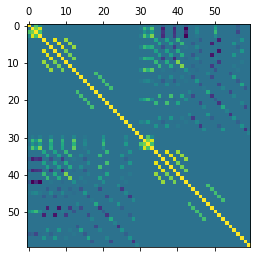

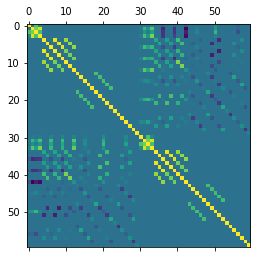

In [21]:
plt.matshow(S(0)),plt.matshow(S(.5))